In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile
import cv2
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from sklearn.metrics import confusion_matrix, classification_report
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


In [ ]:
#data directory
data_dir = '/content/drive/MyDrive/ML-6375/Project/data/'

In [ ]:
#reading data
data = pd.read_csv(data_dir + 'fer2013.csv')

In [ ]:
# data head
data

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


In [ ]:
# Preprocessing
pixels = data['pixels'].tolist()
width, height = 48, 48
faces = []
for pixel_sequence in pixels:
    face = [int(pixel) for pixel in pixel_sequence.split(' ')]
    face = np.asarray(face).reshape(width, height)
    face = cv2.resize(face.astype('uint8'), (width, height))
    faces.append(face.astype('float32'))
faces = np.asarray(faces)
faces = np.expand_dims(faces, -1)
emotions = pd.get_dummies(data['emotion']).values

In [ ]:
data

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


In [ ]:
data['emotion']

0        0
1        0
2        2
3        4
4        6
        ..
35882    6
35883    3
35884    0
35885    3
35886    2
Name: emotion, Length: 35887, dtype: int64

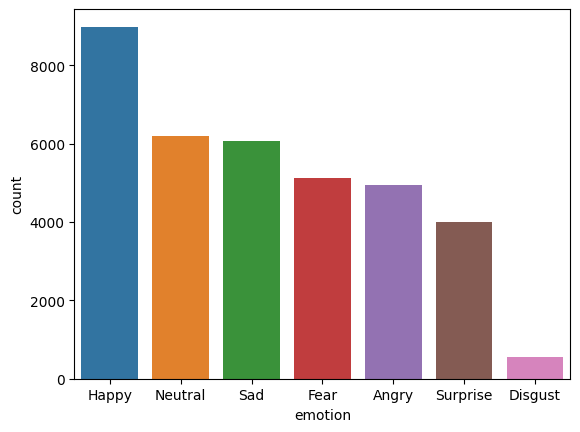

In [ ]:
# Data visualization
emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
data['emotion_labels'] = data['emotion'].apply(lambda x: emotion_labels[int(x)])
emotion_counts = data['emotion_labels'].value_counts().reset_index()
emotion_counts.columns = ['emotion', 'count']

sns.barplot(x='emotion', y='count', data=emotion_counts)
plt.show()

In [ ]:
# Splitting dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(faces, emotions, test_size=0.2, random_state=42)


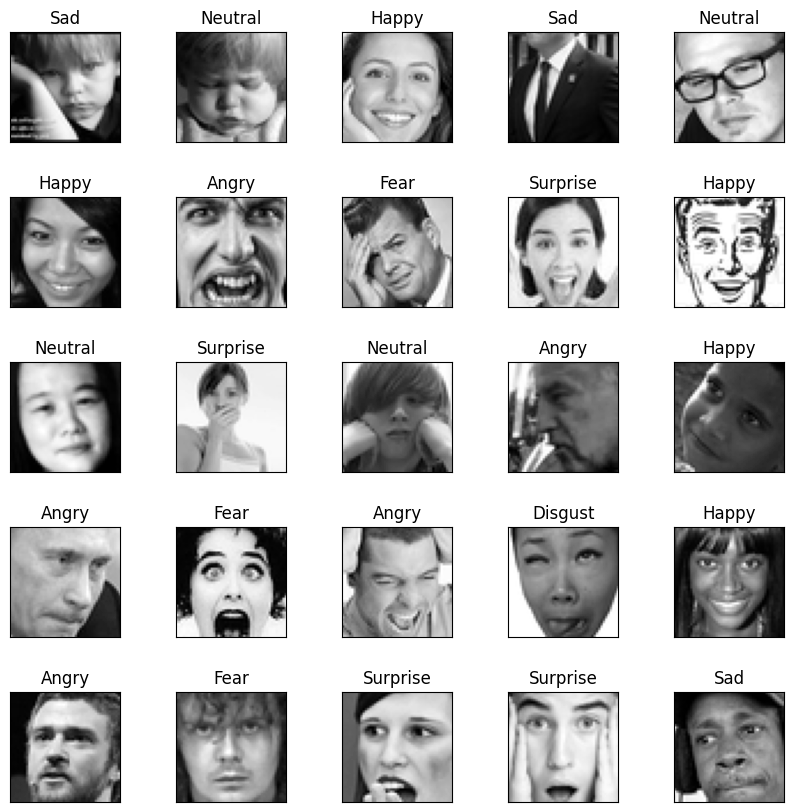

In [ ]:
# Visualize images with emotions
def plot_images_with_emotions(images, emotions, emotion_labels, n_examples=25):
    fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(48, 48), cmap='gray')
        ax.set_title(emotion_labels[np.argmax(emotions[i])])
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

plot_images_with_emotions(X_train, y_train, emotion_labels)

In [ ]:
#identify the faces
import cv2

# Load Haar Cascade Classifier
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def detect_faces(image, cascade, scale_factor=1.1, min_neighbors=5):
    faces = cascade.detectMultiScale(image, scaleFactor=scale_factor, minNeighbors=min_neighbors)
    return faces


In [ ]:
#identify faces
def detect_faces(image, cascade, scale_factor=1.1, min_neighbors=5):
    faces = cascade.detectMultiScale(image, scaleFactor=scale_factor, minNeighbors=min_neighbors)
    return faces

def crop_faces(image, faces):
    cropped_faces = []
    for (x, y, w, h) in faces:
        cropped_face = image[y:y + h, x:x + w]
        cropped_faces.append(cropped_face)
    return cropped_faces

def preprocess_faces(faces, width, height, pixel_width, pixel_height, pixels):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    
    for pixel_sequence in pixels:
        face = [int(pixel) for pixel in pixel_sequence.split(' ')]
        face = np.asarray(face).reshape(width, height)
        face = face.astype('uint8')
        
        detected_faces = detect_faces(face, face_cascade)
        if len(detected_faces) > 0:
            cropped_faces = crop_faces(face, detected_faces)
            resized_face = cv2.resize(cropped_faces[0], (pixel_width, pixel_height))
        else:
            resized_face = cv2.resize(face, (pixel_width, pixel_height))

        faces.append(resized_face.astype('float32'))
    return faces


# Preprocessing
pixels = data['pixels'].tolist()
width, height = 48, 48
pixel_width, pixel_height = 48, 48 
faces = []
faces = preprocess_faces(faces, width, height, pixel_width, pixel_height, pixels)

faces = np.asarray(faces)
faces = np.expand_dims(faces, -1)
emotions = pd.get_dummies(data['emotion']).values

In [ ]:
# Splitting dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(faces, emotions, test_size=0.2, random_state=42)


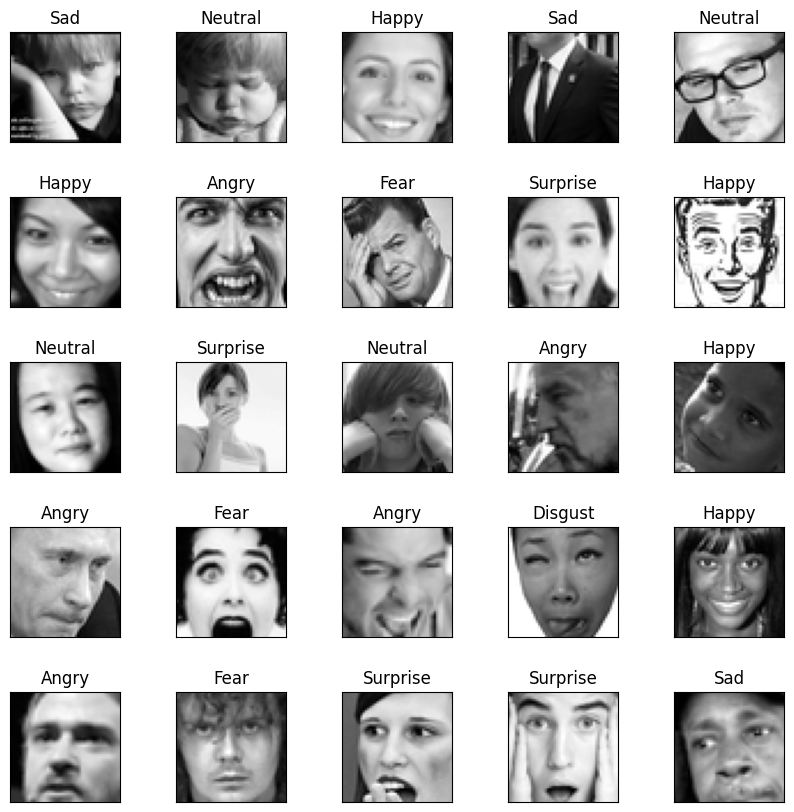

In [ ]:
# Visualize images with emotions
def plot_images_with_emotions(images, emotions, emotion_labels, n_examples=25):
    fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(48, 48), cmap='gray')
        ax.set_title(emotion_labels[np.argmax(emotions[i])])
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

plot_images_with_emotions(X_train, y_train, emotion_labels)

In [ ]:
# Data augmentation
data_generator = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=.1,
    horizontal_flip=True)

In [ ]:
# Loading VGG16 model
vgg = VGG16(include_top=False, input_shape=(48, 48, 3))

In [ ]:
# Modifying the VGG model
for layer in vgg.layers[:-6]:
    layer.trainable = False

x = vgg.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(7, activation='softmax')(x)

model = Model(vgg.input, x)

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# Callbacks
checkpoint = ModelCheckpoint("vgg_fer2013.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto', min_delta=0.0001)

callbacks = [checkpoint, early_stopping, reduce_lr]

In [ ]:
# Train the model
epochs = 100
batch_size = 64

gray_to_rgb = lambda x: np.repeat(x, 3, -1)
X_train_rgb = gray_to_rgb(X_train)
X_test_rgb = gray_to_rgb(X_test)

history = model.fit(data_generator.flow(X_train_rgb, y_train, batch_size=batch_size),
              steps_per_epoch=len(X_train) / batch_size,
              epochs=epochs,
              verbose=1,
              callbacks=callbacks,
              validation_data=(X_test_rgb, y_test))

# Save the model
#model.save('vgg_fer2013_emotion_detection.h5')


Epoch 1/100
449/448 [==============================] - ETA: 0s - loss: 2.4744 - accuracy: 0.2570
Epoch 1: val_accuracy improved from -inf to 0.22541, saving model to vgg_fer2013.h5
448/448 [==============================] - 27s 57ms/step - loss: 2.4744 - accuracy: 0.2570 - val_loss: 8.8239 - val_accuracy: 0.2254 - lr: 1.0000e-04
Epoch 2/100
449/448 [==============================] - ETA: 0s - loss: 2.0935 - accuracy: 0.3315
Epoch 2: val_accuracy did not improve from 0.22541
448/448 [==============================] - 25s 56ms/step - loss: 2.0935 - accuracy: 0.3315 - val_loss: 5.7399 - val_accuracy: 0.1467 - lr: 1.0000e-04
Epoch 3/100
448/448 [============================>.] - ETA: 0s - loss: 1.8128 - accuracy: 0.3949
Epoch 3: val_accuracy improved from 0.22541 to 0.42379, saving model to vgg_fer2013.h5
448/448 [==============================] - 25s 56ms/step - loss: 1.8131 - accuracy: 0.3950 - val_loss: 1.6967 - val_accuracy: 0.4238 - lr: 1.0000e-04
Epoch 4/100
449/448 [================

In [ ]:
# Function to create a model
def create_model(pretrained_model, num_classes=7):
    # Code to create a model using the provided pre-trained model
    pass
